<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/vits/vlms/nanoVLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
## Imports

In [5]:
import math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [6]:
## Variables

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 10
LR = 3e-4
TEMPERATURE = 0.07

In [10]:
## Synthetic Dataset

In [11]:
colors = ["red", "green", "blue", "yellow", "purple", "orange", "pink", "brown", "gray"]
shapes = ["square", "circle", "triangle"]
positions = ["left", "center", "right", "top", "bottom", "top-left", "top-right", "bottom-left", "bottom-right"]

In [12]:
### Drawing image shapes

In [13]:
def draw_sample(color, shape, position, img_size=IMG_SIZE):
  img = Image.new("RGB", (img_size, img_size), "white")
  draw = ImageDraw.Draw(img)
  margin = 6
  w = h = img_size - 2 * margin

  # Calculate the coordinates
  if "left" in position:
    x0 = margin
    x1 = margin + w // 2
  elif "top-left" in position:
    x0 = margin
    x1 = margin + w // 2
  elif "bottom-left" in position:
    x0 = margin
    x1 = margin + w // 2
  elif "right" in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  elif "top-right" in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  elif "bottom-right" in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  else:
    x0 = margin + w // 4
    x1 = margin + h // 2


  # Calculate y coordinates
  if "top" in position:
    y0 = margin
    y1 = margin + h // 2
  elif "top-left" in position:
    y0 = margin
    y1 = margin + h // 2
  elif "top-right" in position:
    y0 = margin
    y1 = margin + h // 2
  elif "bottom" in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif "bottom-left" in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif "bottom-right" in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  else:
    y0 = margin + h // 4
    y1 = margin + 3 * h // 4

  if shape == "square":
    draw.rectangle([x0, y0, x1, y1], fill=color, outline="black")
  elif shape == "circle":
    draw.ellipse([x0, y0, x1, y1], fill=color, outline="black")
  else:
    draw.polygon([(x0 + (x1-x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline="black")

  return img



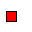

In [16]:
draw_sample("red", "square", "left")